In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label='{ %s | data: %.4f | grad: %.4f }' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; c.label='c'
d = Value(10.0, label='d')
e = c + d; e.label='e'
f = Value(-2.0, label='f')
L = e * f; L.label='L' # L as in loss 

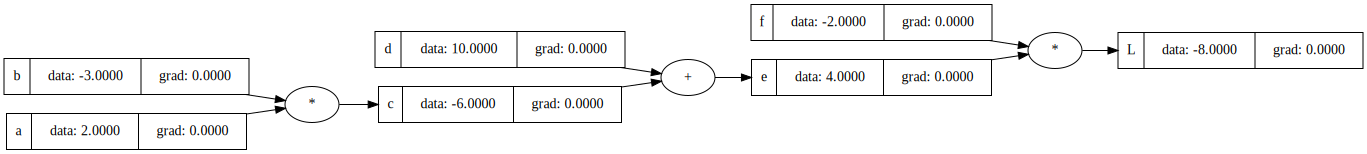

In [5]:
draw_dot(L)

Here, we calculate the derivative of `L` with respect to `a`, i.e., $\frac{\mathrm{d}L}{\mathrm{d}a}$

In [6]:
# Function to not mess up the global scope
def test_1():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L2 = L.data

    print((L2 - L1) / h)

test_1()

6.000000000000227


Here, we calculate the derivative of `L` wrt `L`, i.e., $\frac{\mathrm{d}L}{\mathrm{d}L}$

In [7]:
# Function to not mess up the global scope
def test_2():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L2 = L.data + h

    print((L2 - L1) / h)

test_2()

1.000000000000334


Therefore, $\frac{\mathrm{d}L}{\mathrm{d}L} = \lim_{h \to 0} \frac{L(x + h) - L(x)}{h} = 1$

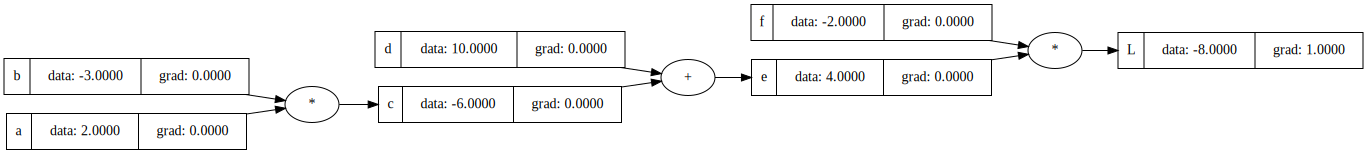

In [8]:
L.grad = 1
draw_dot(L)

Now to find the derivative of `L` wrt `e`.


$L = e \cdot f$

$\frac{\mathrm{d}L}{\mathrm{d}e} = \frac{\mathrm{d}({e \cdot f})}{\mathrm{d}e} = f$

With Limits:

$\frac{\mathrm{d}L}{\mathrm{d}e} = \lim_{h \to 0}\frac{L(e + h) - L(e)}{h}$

$L = e \cdot f$

$\frac{L(e + h) - L(e)}{h} = \frac{(e + h) \cdot f - e \cdot f}{h} = \frac{e \cdot f + h \cdot f - e \cdot f}{h} = \frac{h \cdot f}{h} = f$


Therefore, `e.grad = f`


In [9]:
e.grad = -2.0

On similar lines, to find the derivative of `L` wrt `f`,

$\frac{\mathrm{d}L}{\mathrm{d}f} = \frac{\mathrm{d}({e \cdot f})}{\mathrm{d}f} = e$

With Limits:

$\frac{\mathrm{d}L}{\mathrm{d}f} = \lim_{h \to 0}\frac{L(f + h) - L(f)}{h}$

$L = e \cdot f$

$\frac{L(f + h) - L(f)}{h} = \frac{(f + h) \cdot e - e \cdot f}{h} = \frac{e \cdot f + h \cdot e - e \cdot f}{h} = \frac{h \cdot e}{h} = e$


Therefore, `f.grad = e`


In [10]:
f.grad = 4.0

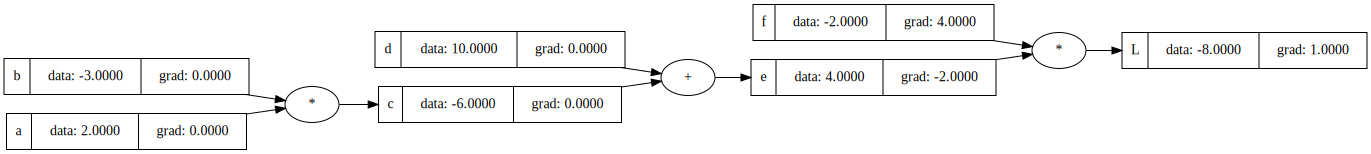

In [11]:
draw_dot(L)

In [12]:
def verify_grad_f_e():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    e.data += h
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L2 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0 + h, label='f')
    L = e * f; L.label='L' # L as in loss 
    L3 = L.data

    print(f'e.grad = {(L2 - L1) / h}')
    print(f'f.grad = {(L3 - L1) / h}')

verify_grad_f_e()

e.grad = -2.000000000000668
f.grad = 3.9999999999995595


Now to find the derivative of `L` wrt `d`, we use the chain rule of calculus

$L = e \cdot f = (d + c) \cdot f$

That is, $e = d + c$

We know that $\frac{\mathrm{d}L}{\mathrm{d}e} = f = -2.0$

Similarly, we can derive that:

$\frac{\mathrm{d}e}{\mathrm{d}d} = \frac{\mathrm{d}(d + c)}{\mathrm{d}d} = 1$

On similar lines, $\frac{\mathrm{d}e}{\mathrm{d}c} = \frac{\mathrm{d}(c + d)}{\mathrm{d}c} = 1$


By chain rule, we can state: $\frac{\mathrm{d}L}{\mathrm{d}d} = \frac{\mathrm{d}L}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}d} = -2.0 \cdot 1 = -2.0$

Similarly, on differentiating `L` wrt `c`
$\frac{\mathrm{d}L}{\mathrm{d}c} = \frac{\mathrm{d}L}{\mathrm{d}e} \cdot \frac{\mathrm{d}e}{\mathrm{d}c} = -2.0 \cdot 1 = -2.0$

In [13]:
c.grad = -2.0
d.grad = -2.0

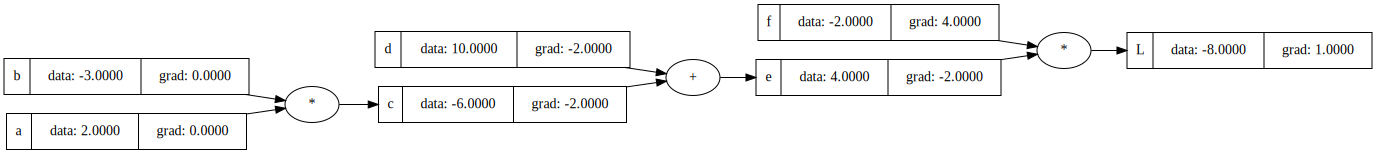

In [14]:
draw_dot(L)

In [15]:
def verify_grad_c_d():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    c.data += h
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L2 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0 + h, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L3 = L.data

    print(f'c.grad = {(L2 - L1) / h}')
    print(f'd.grad = {(L3 - L1) / h}')


verify_grad_c_d()

c.grad = -2.000000000000668
d.grad = -1.9999999999988916


Now to find the derivative of `L` wrt `a` and `b`.


From previous cell: $\frac{\mathrm{d}L}{\mathrm{d}c} = -2.0$

We know that: $c = a \cdot b$

Hence, $\frac{\mathrm{d}c}{\mathrm{d}a} = b = -3.0$

And, $\frac{\mathrm{d}c}{\mathrm{d}b} = a = 2.0$

By chain rule, $\frac{\mathrm{d}L}{\mathrm{d}a} = \frac{\mathrm{d}L}{\mathrm{d}c} \cdot \frac{\mathrm{d}c}{\mathrm{d}a} = -2.0 \cdot -3.0 = 6.0$

Similarly: $\frac{\mathrm{d}L}{\mathrm{d}b} = \frac{\mathrm{d}L}{\mathrm{d}c} \cdot \frac{\mathrm{d}c}{\mathrm{d}b} = -2.0 \cdot 2.0 = -4.0$


In [16]:
def verify_grad_a_b():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L2 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = a * b; c.label='c'
    d = Value(10.0, label='d')
    e = c + d; e.label='e'
    f = Value(-2.0, label='f')
    L = e * f; L.label='L' # L as in loss 
    L3 = L.data

    print(f'a.grad = {(L2 - L1) / h}')
    print(f'b.grad = {(L3 - L1) / h}')
    


verify_grad_a_b()

a.grad = 6.000000000000227
b.grad = -3.9999999999995595


In [17]:
a.grad = 6.0
b.grad = -4.0